In [61]:
!pip install huggingface_hub


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [62]:
!pip install wandb==0.16.0


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [63]:
!pip install --upgrade datasets


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [253]:
from datasets import load_dataset
dataset = load_dataset("nateraw/pascal-voc-2012",split = 'train')

In [254]:
# 데이터셋의 기본 정보 출력
print("데이터셋 정보:")
print(dataset)

# 데이터셋의 첫 번째 샘플 출력
print("\n첫 번째 데이터 샘플:")
print(dataset[0])

# 데이터셋의 특정 필드 이름 및 데이터 타입 탐색
print("\n필드 이름 및 데이터 타입:")
for field, field_type in dataset.features.items():
    print(f"{field}: {field_type}")

데이터셋 정보:
Dataset({
    features: ['image', 'mask'],
    num_rows: 1464
})

첫 번째 데이터 샘플:
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x281 at 0x7F8A94353610>, 'mask': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=500x281 at 0x7F8C353E1ED0>}

필드 이름 및 데이터 타입:
image: Image(decode=True, id=None)
mask: Image(decode=True, id=None)


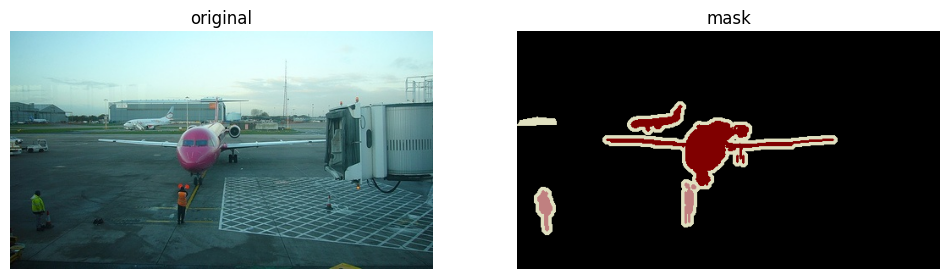

In [255]:
import matplotlib.pyplot as plt

# 첫 번째 데이터 샘플을 로드
first_sample = dataset[0]
image = first_sample['image']
mask = first_sample['mask']

# 이미지와 마스크 표시
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 원본 이미지
ax[0].imshow(image)
ax[0].set_title('original')
ax[0].axis('off')

# 마스크 이미지
ax[1].imshow(mask)
ax[1].set_title('mask')
ax[1].axis('off')

plt.show()


In [256]:
import os
import math
import numpy as np
import tensorflow as tf
import random
import pickle

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread, imshow,show
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [257]:
# random seed 설정
tf.random.set_seed(42)
random.seed(1234)

In [258]:
image_width, image_height = 224, 224

from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:  # 훈련용 데이터일 경우
        return Compose([
            HorizontalFlip(p=0.5),  # 50%의 확률로 좌우대칭
            RandomSizedCrop(        # 50%의 확률로 RandomSizedCrop
                min_max_height=(100, 200),  # 원본 이미지 크기에 맞게 조정
                w2h_ratio=image_width / image_height,
                height=image_height,
                width=image_width,
                p=0.5
            ),
            Resize(                 # 입력이미지를 224X224로 resize
                width=image_width,
                height=image_height
            )
        ])
    else:  # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다.
        return Compose([
            Resize(
                width=image_width,
                height=image_height
            )
        ])


In [259]:
from PIL import Image
import numpy as np

# 이미지와 마스크를 NumPy 배열로 변환
input_images = np.array(dataset[0]['image'])
input_labels = np.array( dataset[0]['mask'])

# 변환된 배열의 형태 확인
print("Images shape:", input_images.shape)
print("Labels shape:", input_labels.shape)



Images shape: (281, 500, 3)
Labels shape: (281, 500, 3)


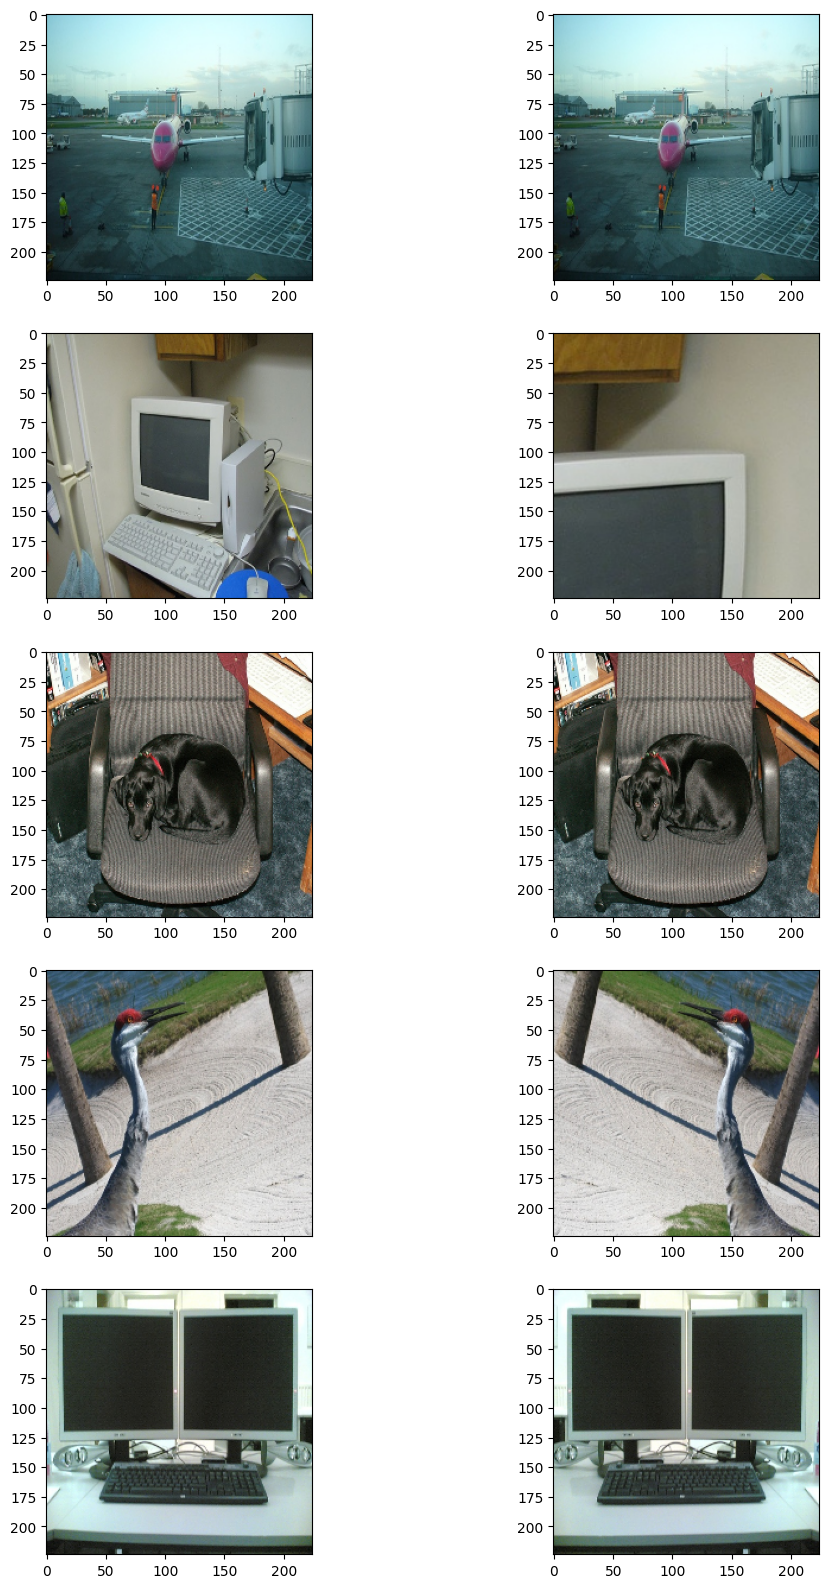

In [260]:
# 데이터 확인
import numpy as np

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image =  np.array(dataset[i]['image'])
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [261]:
input_images = np.array(dataset[0]['image'])
input_labels = np.array( dataset[0]['mask'])

In [262]:
image = input_images
label = input_labels
print(image.shape, label.shape)

(281, 500, 3) (281, 500, 3)


In [263]:
data = {
  "image": image,
  "mask": mask,
  }
image_data = {"image":image,"mask":label}
resized = augmentation_train(**image_data)
# resized_label = augmentation_test(**label_data)
print(resized['image'].shape, resized['mask'].shape)

(224, 224, 3) (224, 224, 3)


In [264]:
# data = {
#   "image": image,
#   "mask": mask,
#   }
# image_data = {"image":image,"mask":label}
# resized = augmentation_test(**image_data)
# # resized_label = augmentation_test(**label_data)
# print(resized['image'].shape, resized['mask'].shape)

In [265]:
import numpy as np
from PIL import Image

def extract_class_color_mapping(masks):
    """
    마스크 이미지들에서 클래스별 색상 매핑을 추출하는 함수
    :param masks: 마스크 이미지의 리스트
    :return: 클래스와 색상의 매핑 딕셔너리
    """
    color_mapping = {}
    class_id = 0

    target_color = (224, 224, 192)  # 변경하고자 하는 원본 색상
    new_color = (0, 0, 0)           # 대체할 새로운 색상

    for mask in masks:
        # 마스크 이미지를 NumPy 배열로 변환
        mask_np = np.array(mask)
        # 고유한 색상 찾기
        unique_colors = np.unique(mask_np.reshape(-1, mask_np.shape[2]), axis=0)

        for color in unique_colors:
            # 특정 색상을 새로운 색상으로 변경
            if tuple(color) == target_color:
                color = new_color

            # 색상을 튜플로 변환
            color_tuple = tuple(color)
            # 새로운 색상이면 클래스 ID 할당
            if color_tuple not in color_mapping:
                color_mapping[color_tuple] = class_id
                class_id += 1

    return color_mapping



def map_color_mask_to_integer(color_mask, mapping):
    integer_mask = np.zeros(color_mask.shape[:-1], dtype=np.uint8)
    for row in range(color_mask.shape[0]):
        for col in range(color_mask.shape[1]):
            color = tuple(color_mask[row, col])
            if color in mapping:
                integer_mask[row, col] = mapping[color]
    return integer_mask

### 클래스 컬러 매핑 딕셔너리 만들기 

(없으면 만들어서 저장 ,있으면 불러오기)

In [266]:
# 데이터셋에서 마스크 목록 추출
masks = [sample['mask'] for sample in dataset]
pickle_file = 'class_color_mapping.pkl'
if not os.path.exists(pickle_file):
    # masks 변수는 이미 정의되어 있어야 합니다.
    class_color_mapping = extract_class_color_mapping(masks)

    # 추출한 매핑을 pickle 파일로 저장
    with open(pickle_file, 'wb') as file:
        pickle.dump(class_color_mapping, file)
else:
    # 파일이 이미 존재하는 경우, pickle 파일에서 데이터 불러오기
    with open(pickle_file, 'rb') as file:
        class_color_mapping = pickle.load(file)
print(class_color_mapping)

{(0, 0, 0): 0, (128, 0, 0): 1, (192, 128, 128): 2, (0, 64, 128): 3, (64, 0, 128): 4, (192, 0, 0): 5, (128, 128, 0): 6, (128, 0, 128): 7, (0, 0, 128): 8, (192, 128, 0): 9, (128, 192, 0): 10, (64, 128, 128): 11, (192, 0, 128): 12, (64, 128, 0): 13, (0, 128, 0): 14, (128, 128, 128): 15, (64, 0, 0): 16, (0, 192, 0): 17, (0, 128, 128): 18, (0, 64, 0): 19, (128, 64, 0): 20}


In [269]:
def create_inverse_mapping(class_color_mapping):
    """
    클래스 ID에서 색상으로의 역 매핑을 생성하는 함수
    :param class_color_mapping: 클래스와 색상의 매핑 딕셔너리
    :return: 역 매핑 딕셔너리
    """
    inverse_mapping = {class_id: color for color, class_id in class_color_mapping.items()}
    return inverse_mapping

In [270]:
pickle_file_inverse_mapping = 'inverse_mapping.pkl'
if not os.path.exists(pickle_file_inverse_mapping):

    inverse_mapping = create_inverse_mapping(class_color_mapping)
    # 추출한 매핑을 pickle 파일로 저장
    with open(pickle_file_inverse_mapping, 'wb') as file:
        pickle.dump(inverse_mapping, file)
else:
    # 파일이 이미 존재하는 경우, pickle 파일에서 데이터 불러오기
    with open(pickle_file_inverse_mapping, 'rb') as file:
        inverse_mapping = pickle.load(file)
print(inverse_mapping)

{0: (0, 0, 0), 1: (128, 0, 0), 2: (192, 128, 128), 3: (0, 64, 128), 4: (64, 0, 128), 5: (192, 0, 0), 6: (128, 128, 0), 7: (128, 0, 128), 8: (0, 0, 128), 9: (192, 128, 0), 10: (128, 192, 0), 11: (64, 128, 128), 12: (192, 0, 128), 13: (64, 128, 0), 14: (0, 128, 0), 15: (128, 128, 128), 16: (64, 0, 0), 17: (0, 192, 0), 18: (0, 128, 128), 19: (0, 64, 0), 20: (128, 64, 0)}


In [271]:
a = tf.keras.utils.to_categorical([0, 1, 3, 2], num_classes=4)
print(a)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


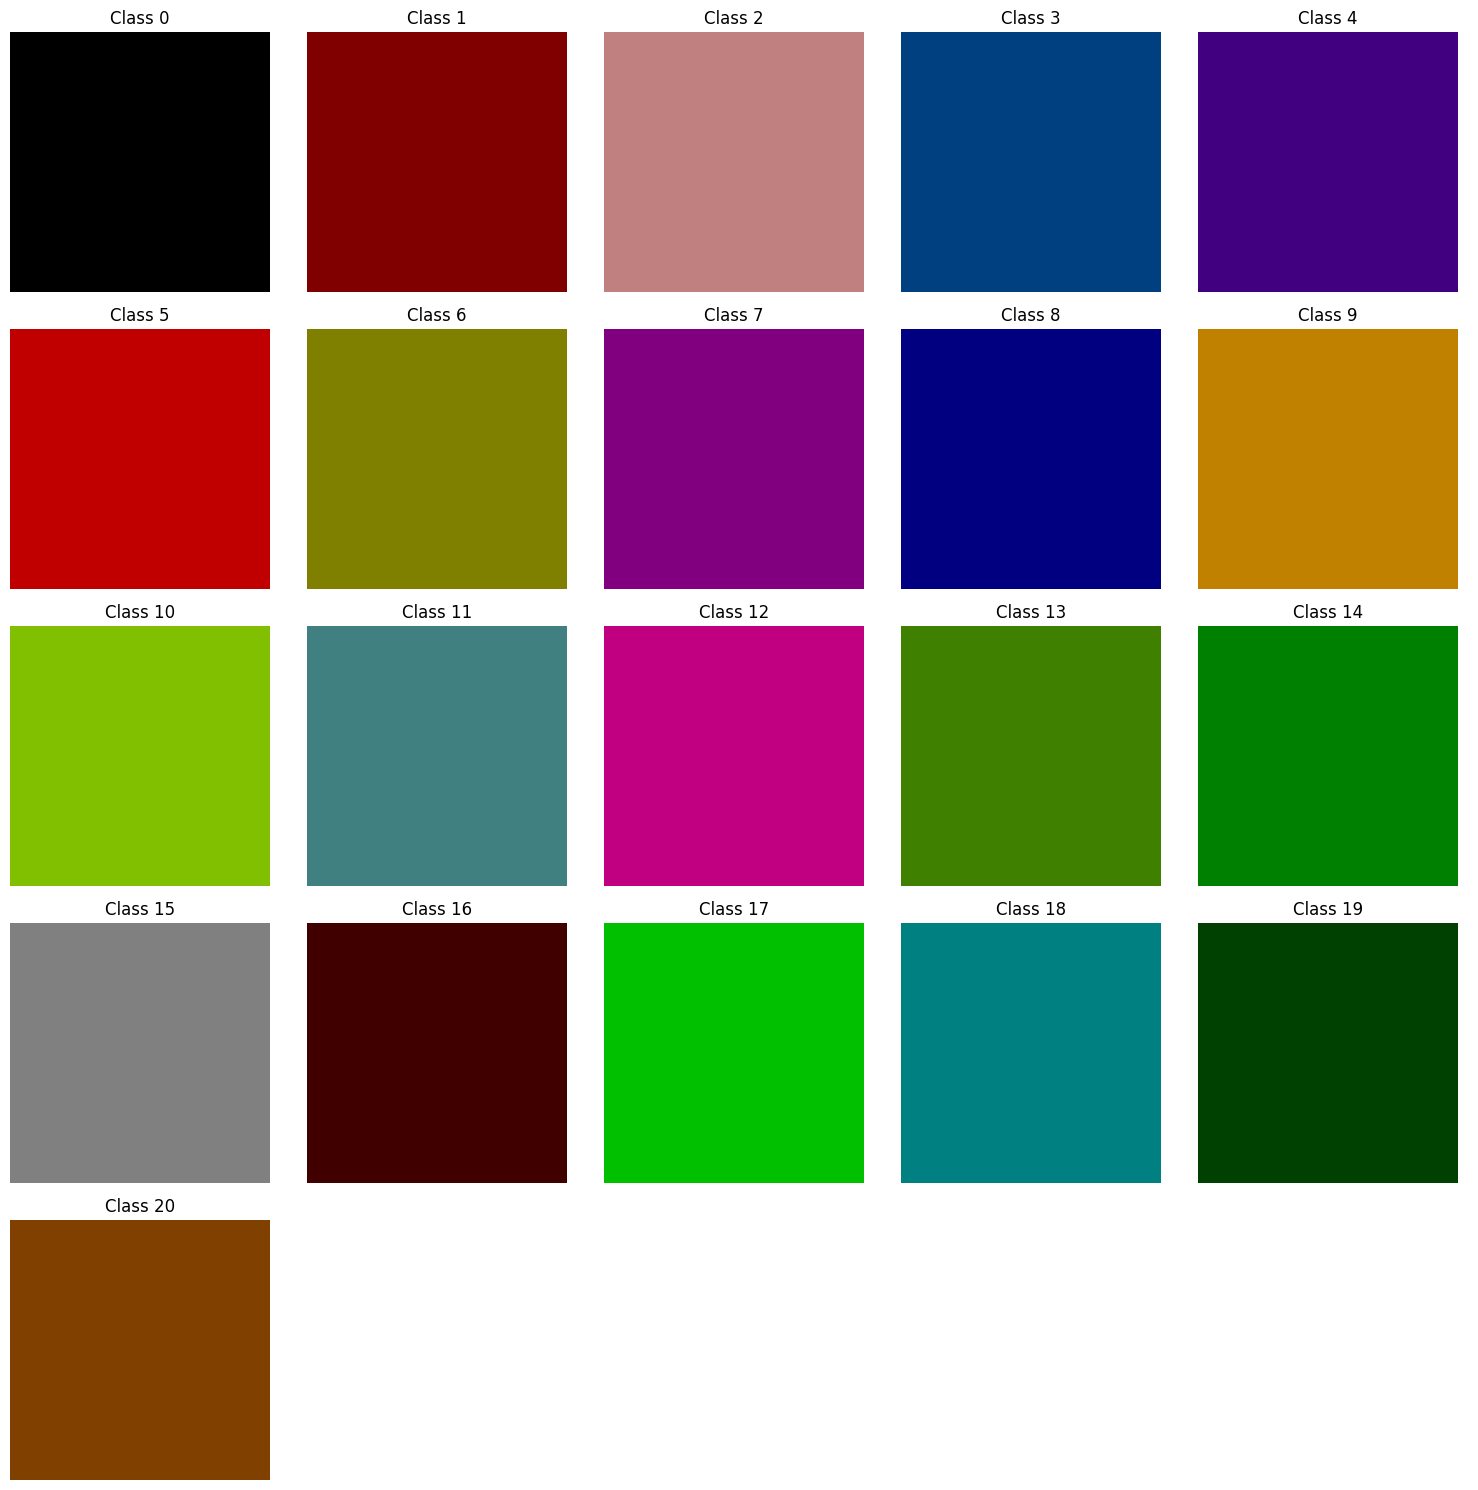

In [272]:
# 5행 5열의 서브플롯 생성
plt.figure(figsize=(15, 15))
for class_id, color in inverse_mapping.items():
    ax = plt.subplot(5, 5, class_id + 1)
    ax.set_title(f"Class {class_id}")
    ax.imshow(np.full((10, 10, 3), color, dtype=np.uint8))  # 색상으로 채운 작은 이미지 생성
    ax.axis('off')

# 나머지 빈 서브플롯 숨기기
for i in range(len(inverse_mapping) + 1, 26):
    ax = plt.subplot(5, 5, i)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [273]:
np.array(resized['mask']).shape

(224, 224, 3)

In [326]:
inverse_mapping= {0: (0, 0, 0),
 1: (128, 0, 0),
 2: (192, 128, 128),
 3: (0, 64, 128),
 4: (64, 0, 128),
 5: (192, 0, 0),
 6: (128, 128, 0),
 7: (128, 0, 128),
 8: (0, 0, 128),
 9: (192, 128, 0),
 10: (128, 192, 0),
 11: (64, 128, 128),
 12: (192, 0, 128),
 13: (64, 128, 0),
 14: (0, 128, 0),
 15: (128, 128, 128),
 16: (64, 0, 0),
 17: (0, 192, 0),
 18: (0, 128, 128),
 19: (0, 64, 0),
 20: (128, 64, 0)}

In [327]:
class_color_mapping ={(0, 0, 0): 0,
 (128, 0, 0): 1,
 (192, 128, 128): 2,
 (0, 64, 128): 3,
 (64, 0, 128): 4,
 (192, 0, 0): 5,
 (128, 128, 0): 6,
 (128, 0, 128): 7,
 (0, 0, 128): 8,
 (192, 128, 0): 9,
 (128, 192, 0): 10,
 (64, 128, 128): 11,
 (192, 0, 128): 12,
 (64, 128, 0): 13,
 (0, 128, 0): 14,
 (128, 128, 128): 15,
 (64, 0, 0): 16,
 (0, 192, 0): 17,
 (0, 128, 128): 18,
 (0, 64, 0): 19,
 (128, 64, 0): 20,
 (224, 224, 192):0
 }

In [328]:
# 컬러 시맨틱 세그멘테이션 마스크를 정수로 변환
integer_mask = map_color_mask_to_integer(np.array(resized['mask']), class_color_mapping)
integer_mask.shape

(224, 224)

In [330]:
def map_integer_mask_to_color(integer_mask, reverse_mapping):
    color_mask = np.zeros((integer_mask.shape[0], integer_mask.shape[1], 3), dtype=np.uint8)
    for row in range(integer_mask.shape[0]):
        for col in range(integer_mask.shape[1]):
            class_idx = integer_mask[row, col]
            color = reverse_mapping[class_idx]
            # 컬러 값을 [0, 255] 범위로 스케일링
            scaled_color = np.clip(color, 0, 255)
            color_mask[row, col] = scaled_color

    return color_mask

restored_color_mask = map_integer_mask_to_color(integer_mask, inverse_mapping)

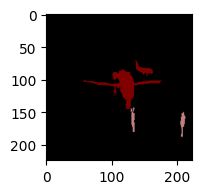

In [331]:
plt.subplot(1, 3, 2)
plt.imshow(restored_color_mask)

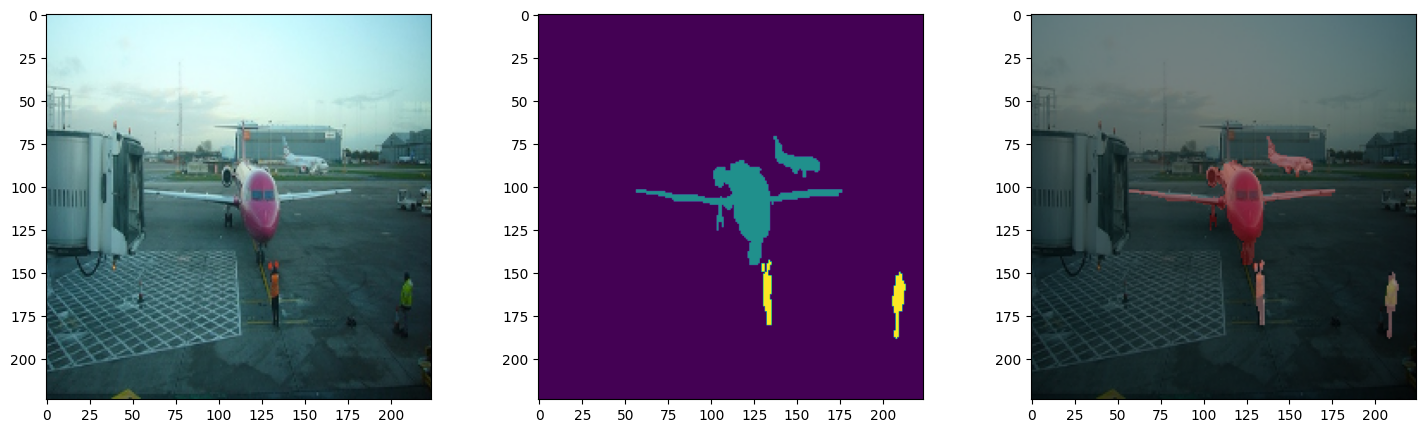

In [332]:
plt.figure(figsize = (18,5))
plt.subplot(1, 3, 1)
plt.imshow(resized["image"])
plt.subplot(1, 3, 2)
plt.imshow(integer_mask)
plt.subplot(1, 3, 3)
plt.imshow(Image.blend(Image.fromarray(resized["image"]),Image.fromarray(restored_color_mask), alpha=0.5))
plt.show()

In [333]:
inverse_mapping

{0: (0, 0, 0),
 1: (128, 0, 0),
 2: (192, 128, 128),
 3: (0, 64, 128),
 4: (64, 0, 128),
 5: (192, 0, 0),
 6: (128, 128, 0),
 7: (128, 0, 128),
 8: (0, 0, 128),
 9: (192, 128, 0),
 10: (128, 192, 0),
 11: (64, 128, 128),
 12: (192, 0, 128),
 13: (64, 128, 0),
 14: (0, 128, 0),
 15: (128, 128, 128),
 16: (64, 0, 0),
 17: (0, 192, 0),
 18: (0, 128, 128),
 19: (0, 64, 0),
 20: (128, 64, 0)}

In [334]:
class_color_mapping

{(0, 0, 0): 0,
 (128, 0, 0): 1,
 (192, 128, 128): 2,
 (0, 64, 128): 3,
 (64, 0, 128): 4,
 (192, 0, 0): 5,
 (128, 128, 0): 6,
 (128, 0, 128): 7,
 (0, 0, 128): 8,
 (192, 128, 0): 9,
 (128, 192, 0): 10,
 (64, 128, 128): 11,
 (192, 0, 128): 12,
 (64, 128, 0): 13,
 (0, 128, 0): 14,
 (128, 128, 128): 15,
 (64, 0, 0): 16,
 (0, 192, 0): 17,
 (0, 128, 128): 18,
 (0, 64, 0): 19,
 (128, 64, 0): 20,
 (224, 224, 192): 0}

In [ ]:
import os
import math
import random
import numpy as np
from glob import glob
from skimage.io import imread
from PIL import Image
from datasets import DatasetDict
from io import BytesIO
from tensorflow.keras.utils import to_categorical
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self , batch_size=16, img_size=(224, 224, 3), output_size=(224, 224),
                 is_train=True, is_val=False, augmentation=None):
        '''
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.batch_size = batch_size
        self.is_train = is_train
        self.is_val = is_val
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        self.data = self.load_dataset().to_list()

    def load_dataset(self):
        dataset = load_dataset("nateraw/pascal-voc-2012", split='train')
        shuffled_dataset = dataset.shuffle(seed=42)

        # 데이터셋 분할 비율 설정
        train_ratio = 0.7
        val_ratio = 0.2
        test_ratio = 0.1

        # 훈련, 검증, 테스트 세트로 분할
        split_datasets = shuffled_dataset.train_test_split(test_size=(val_ratio + test_ratio))
        test_dataset = split_datasets['test'].train_test_split(test_size=test_ratio / (val_ratio + test_ratio))

        # 최종적으로 분할된 데이터셋
        data = DatasetDict({
            'train': split_datasets['train'],
            'validation': test_dataset['train'],
            'test': test_dataset['test']
        })

        if self.is_train:
            return data['train']
        elif self.is_val:
            return data['validation']
        else:
            return data['test']
    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 인덱스에 맞는 데이터 배치를 가져옵니다.
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_data = self.data[start:end]

        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size[:2],21])
        for i, data in enumerate(batch_data):
            img, mask = data["image"]["bytes"], data["mask"]["bytes"]
            image = Image.open(BytesIO(img))
            mask = Image.open(BytesIO(mask))
            _input = np.array(image)
            _output = np.array(mask)
            dataset = {'image': _input, 'mask': _output}
            augmented = self.augmentation(**dataset) if self.augmentation else dataset

            integer_mask = map_color_mask_to_integer(augmented['mask'], class_color_mapping)
            # unique_values, counts = np.unique(integer_mask, return_counts=True)

            # 고유한 값들의 개수 출력
            # num_unique_values = len(unique_values)
            # print(unique_values)
            # print("Number of unique values:", num_unique_values)
            _output = to_categorical(integer_mask, num_classes=21)
            outputs[i] = _output
            image_array = augmented["image"] / 255.0
            inputs[i] = image_array

        return inputs, outputs



    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train:
            np.random.shuffle(self.indexes)
        return self.indexes


In [ ]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = DataGenerator(
    augmentation=augmentation,
)
val_generator = DataGenerator(
    augmentation=test_preproc,
    is_train = False,
    is_val = True
)
test_generator = DataGenerator(
    augmentation=test_preproc,
    is_train = False,
    is_val = False
)

In [372]:
train_generator.batch_size,val_generator.batch_size,test_generator.batch_size

(16, 16, 16)

In [373]:
len(train_generator),len(val_generator),len(test_generator) # *16 해야 데이터 수 근사

(64, 19, 10)

In [374]:
for image, mask in train_generator:
        sample_image, sample_mask = image, mask
        break
sample_image.shape, sample_mask.shape

((16, 224, 224, 3), (16, 224, 224, 21))

In [ ]:
def display(display_list, titles=[], display_string=None):
    ''' displays list of images/masks'''
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        if display_string and i == 1:
            plt.xlabel(display_string, fontsize=12)
        try:
            img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
        except: # mask => 1-channel
            img_arr = display_list[i]
        plt.imshow(img_arr)
    
    plt.show()

def show_image_from_dataset(dataset,n_show = 2):
    
    for i in range(n_show):
        for image, mask in dataset:
            sample_image, sample_mask = image, mask
            break
        display([sample_image[0], sample_mask[0]], titles=['Image', 'True Mask'])

>>>>>> Train Image
[0 2 8]
Number of unique values: 3
[0 8]
Number of unique values: 2
[ 0  2 11]
Number of unique values: 3
[ 0 16]
Number of unique values: 2
[ 0  4 17]
Number of unique values: 3
[ 0  5  9 19]
Number of unique values: 4
[ 0 13]
Number of unique values: 2
[0 8]
Number of unique values: 2
[0 2]
Number of unique values: 2
[ 0  2 13]
Number of unique values: 3
[0 7]
Number of unique values: 2
[ 0  2 14]
Number of unique values: 3
[ 0  2 15 18]
Number of unique values: 4
[ 0 15]
Number of unique values: 2
[ 0 16]
Number of unique values: 2
[0 1]
Number of unique values: 2


TypeError: Invalid shape (224, 224, 20) for image data

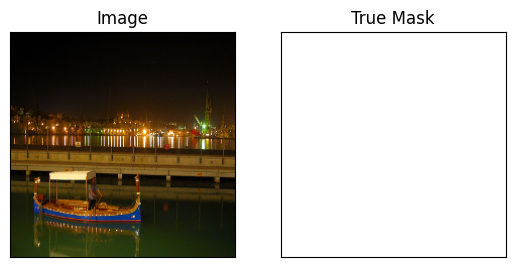

In [352]:
# display an image from the train set
print('>>>>>> Train Image')
show_image_from_dataset(val_generator)
# display an image from the test set
print('>>>>>> Test Image')
show_image_from_dataset(test_generator)

In [353]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [375]:
import tensorflow as tf
from tensorflow import keras


import matplotlib.pyplot as plt




from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import utils

In [376]:
def conv_block(filters, x):
    x = Conv2D(filters, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)  # x = Dropout(0.5)(x)
    x = Conv2D(filters, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)  # x = Dropout(0.5)(x)
    return x
def encoder(filters, x) :
    x = conv_block(filters, x)
    pool = MaxPooling2D(pool_size =(2,2))(x)
    return x, pool
def decoder(filters, x, concat):
    x = Conv2DTranspose(filters, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x)
    x = concatenate([concat, x], axis=3)
    x = conv_block(filters, x)
    return x
def get_outputs(x):
    x = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x)     
    x = Conv2D(21, 1, activation='softmax')(x)
    return x

In [377]:
def build_unet(input_shape=(224,224,3)):
    inputs = Input(input_shape)
    
    filters = [64, 128, 256, 512, 1024]
    
    #contracting path
    e1, p1 = encoder(filters[0], inputs)
    e2, p2 = encoder(filters[1], p1)
    e3, p3 = encoder(filters[2], p2)
    e4, p4 = encoder(filters[3], p3)
    
    # bridge
    b1 = conv_block(filters[4], p4)
    
    #expanding path
    d4 = decoder(filters[3], b1, e4)
    d3 = decoder(filters[2], d4, e3)
    d2 = decoder(filters[1], d3, e2)
    d1 = decoder(filters[0], d2, e1)
    
    # output
    outputs = get_outputs(d1)
    
    #model
    model = Model(inputs = inputs, outputs = outputs)
    return model

In [378]:
unet = build_unet()

In [379]:
DATA_PATH =  '.'

In [380]:
UNET_PATH = DATA_PATH +'/UNET.h5'

In [381]:
MODEL_PATH = DATA_PATH +'/UNET.keras'

In [382]:
unet.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics=['accuracy'])

In [383]:
callbacks = keras.callbacks.ModelCheckpoint(
    filepath = MODEL_PATH,
    save_best_only = True,
    save_weights_only = False,
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1
)

In [384]:
EPOCHS=10

In [385]:
unet_history = unet.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    callbacks = [callbacks]
)

Epoch 1/10


2024-01-10 18:03:54.917885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:132: Filling up shuffle buffer (this may take a while): 3 of 8
2024-01-10 18:04:14.477705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:132: Filling up shuffle buffer (this may take a while): 7 of 8
2024-01-10 18:04:19.353506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3642 - loss: 3.1188
Epoch 1: val_accuracy improved from -inf to 0.27618, saving model to ./UNET.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 383s 5s/step - accuracy: 0.3666 - loss: 3.1177 - val_accuracy: 0.2762 - val_loss: 4.3008
Epoch 2/10


/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.27618
64/64 ━━━━━━━━━━━━━━━━━━━━ 45s 697ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2762 - val_loss: 4.3008
Epoch 3/10


2024-01-10 18:10:52.129465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:132: Filling up shuffle buffer (this may take a while): 3 of 8
2024-01-10 18:11:11.344169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:132: Filling up shuffle buffer (this may take a while): 7 of 8
2024-01-10 18:11:16.206046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6681 - loss: 2.9520
Epoch 3: val_accuracy improved from 0.27618 to 0.77019, saving model to ./UNET.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 361s 5s/step - accuracy: 0.6683 - loss: 2.9517 - val_accuracy: 0.7702 - val_loss: 2.6482
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.77019
64/64 ━━━━━━━━━━━━━━━━━━━━ 45s 696ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7702 - val_loss: 2.6482
Epoch 5/10


2024-01-10 18:17:37.426998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:132: Filling up shuffle buffer (this may take a while): 3 of 8


In [ ]:
print('asd')

asd
